In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data=300
df=pd.read_csv("Data_all.csv", header=None)
data_imp=np.array(df, dtype=float)
scaler=MinMaxScaler()
data_raw=scaler.fit_transform(data_imp)
val_data=data_raw[train_data:350,:]
#test_data=data_raw[320:350,0:3]
data=data_raw[0:train_data, :]
np.random.shuffle(data)
#min_max_scaler = preprocessing.MinMaxScaler()
#StandardScaler = preprocessing.StandardScaler()
#data = StandardScaler.fit_transform(data_raw)
data


array([[0.62171822, 0.5020405 , 0.43688725, 0.50821714, 0.43976295,
        0.43413125],
       [0.6339695 , 0.26556049, 0.36835853, 0.28682281, 0.18509608,
        0.36991903],
       [0.41429759, 0.48476187, 0.57197643, 0.31988804, 0.28431912,
        0.56817442],
       ...,
       [0.24327272, 0.49641578, 0.37831427, 0.19043207, 0.18500874,
        0.37010292],
       [0.91289181, 0.19595713, 0.37688256, 0.45090225, 0.29085919,
        0.38372174],
       [0.81028385, 0.33396011, 0.35767788, 0.50052018, 0.37683958,
        0.36054987]])

In [3]:

s=20  #sampling size
seed_size=20 #size of seed data
q=5 #query size
n=int((train_data-seed_size)/s) # number of iteration needed to go through all samples

In [4]:
#Defining seed data
seed_data=data[0:seed_size,:]
new_data=pd.DataFrame(seed_data)
k=seed_data.shape[0]

In [5]:
#GP model for random sampling
def gp_eval(X, y):
    #n=new_data.shape[0]
    #X=new_data[:, 0:2]
    #y=new_data[:,2]
    # Instantiate a Gaussian Process model
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    kernel = 1.0 * Matern(length_scale=0.1, nu=1.5)
    gp_eval = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp_eval.fit(X, y)
    r2_score=gp.score(X,y)
    print("GP model fit score is=",r2_score)
    #RMSE Error evaluation
    y_val_pred=gp_eval.predict(val_data[:, 0:3])
    tt=np.sqrt(np.mean((val_data[:, 3:6]-y_val_pred)**2))
    print("Random sampling RMSE value is =",tt)
    
    return tt

In [6]:
mse=[]
mse_random=[]
rmse=[]
rmse_random= []
for i in range(n):
    X=new_data.iloc[:, 0:3]
    y=new_data.iloc[:,3:6]
    # Instantiate a Gaussian Process model
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)
    r2_score=gp.score(X,y)
    print("GP model fit score is=",r2_score)
    #Evaluate current model against the validation set
    #RMSE Error evaluation
    y_val_pred=gp.predict(val_data[:, 0:3])
    rmse_cal=np.sqrt(np.mean((val_data[:, 3:6]-y_val_pred)**2))
    mse_cal=np.mean((val_data[:, 3:6]-y_val_pred)**2)
    print("Final rmse value is =",rmse_cal)
    rmse.append(rmse_cal)
    mse.append(mse_cal)
    #pool-based sampling from unlabeled pool
    XX=data[k+i*s:k+(i+1)*s, 0:3]   #taking the next few samples to predict variance
    y_pred,var =gp.predict(XX, return_std=True)  #predict variance
    sigma=var
    print(sigma)
    #Finding maximum variance of the new samples,Rank them and select top 5
    var_pred=pd.DataFrame(sigma, columns=["sigma"])
    new_input=pd.DataFrame(data[k+i*s:k+(i+1)*s,0:6])
    md=pd.concat([new_input, var_pred], axis=1)
    sorted_data=md.sort_values(by=['sigma'], ascending=False)
    #select top 5
    c_data=sorted_data.iloc[0:q,:]
    #concat the ne
    df_1=pd.DataFrame(new_data)
    new_data=pd.concat([df_1, c_data], axis=0)
    vv=new_data.shape[0]
    print(vv)
    #print(new_data)
    #use random sampling

    if i==0:
        rand_rmse=gp_eval(df_1.iloc[:, 0:3], df_1.iloc[:, 3:6])
     #   rand_mse=gp_eval2(df_1.iloc[:, 0:3], df_1.iloc[:, 3:6])
    else:
        df_unlabel=pd.DataFrame(data[k+i*s:k+(i+1)*s,:])
        #df_unlabel=df.iloc[20:400,0:2]
        df_add=df_unlabel.sample(n=q)
        data_random=pd.concat([df_1, df_add], axis=0)
        rand_rmse=gp_eval(data_random.iloc[:, 0:3], data_random.iloc[:,3:6])
      #  rand_mse=gp_eval2(data_random.iloc[:, 0:3], data_random.iloc[:,3:6])
    rmse_random.append(rand_rmse)
    #mse_random.append(rand_mse)
print (mse)
print(mse_random)

GP model fit score is= 0.99999999999937
Final rmse value is = 0.00036078531902543755
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
25
GP model fit score is= 0.99999999999937
Random sampling RMSE value is = 0.0003607651280775292
GP model fit score is= 0.9999999999966575
Final rmse value is = 0.00016434641349960871
[ 0.         16.16379781  0.         47.06202157  0.          0.
  0.          0.          0.         65.36951887 26.15542856  0.
 32.81480176 17.43703073  0.          8.584837    0.          0.
 22.43317524 46.99578568]
30
GP model fit score is= 0.9999998333225915
Random sampling RMSE value is = 0.00014224114337288736
GP model fit score is= 0.9999999999972865
Final rmse value is = 0.00013369118979884097
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
35
GP model fit score is= 0.9999999913186304
Random sampling RMSE value is = 0.00012692069030282305
GP model fit score is= 0.9999999999905999
Final rmse value is = 0.00012870494440241678
[147.3318824

In [7]:
#random learning from the original pool
rmse_rand_orig= []
mse_rand_orig= []
for i in range(n):
        df_seed=pd.DataFrame(data[0:seed_size,:])
        if i==0:
            rand_rmse=gp_eval(df_seed.iloc[0:seed_size, 0:3], df_seed.iloc[0:seed_size, 3:6])
            #rand_mse=gp_eval2(df_seed.iloc[0:seed_size, 0:3], df_seed.iloc[0:seed_size, 3:6])
        else:
            df_unlabel=pd.DataFrame(data[seed_size:train_data,:])
            #df_unlabel=df.iloc[20:400,0:2]
            df_add=df_unlabel.sample(n=q*i)
            data_random=pd.concat([df_seed, df_add], axis=0)
            rand_rmse=gp_eval(data_random.iloc[:, 0:3], data_random.iloc[:, 3:6])
            #rand_mse=gp_eval2(data_random.iloc[:, 0:3], data_random.iloc[:, 3:6])
            ll=data_random.shape[0]
            print(ll)
            print(i)

        rmse_rand_orig.append(rand_rmse)
        #mse_rand_orig.append(rand_mse)
print(rmse_rand_orig)

GP model fit score is= 0.9999999999966666
Random sampling RMSE value is = 0.0003607451774552805
GP model fit score is= 0.999999995037321
Random sampling RMSE value is = 0.0001699041327887217
25
1
GP model fit score is= 0.9999999432183506
Random sampling RMSE value is = 0.00017069007022672744
30
2
GP model fit score is= 0.9999999828268165
Random sampling RMSE value is = 0.0001285622479106159
35
3
GP model fit score is= 0.9999999727390564
Random sampling RMSE value is = 0.0002183387584382018
40
4
GP model fit score is= 0.9999998692540744
Random sampling RMSE value is = 0.00011185809189429836
45
5
GP model fit score is= 0.999999998311967
Random sampling RMSE value is = 0.00012561519348292143
50
6
GP model fit score is= 0.9999999724555105
Random sampling RMSE value is = 0.00011913409244478867
55
7
GP model fit score is= 0.9999999509580482
Random sampling RMSE value is = 8.402564324669066e-05
60
8
GP model fit score is= 0.9999999074553114
Random sampling RMSE value is = 6.209129483948853e-0

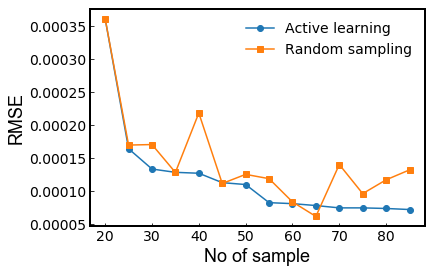

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
m=np.array(list(range(seed_size,seed_size+q*n, q)))
plt.plot(m,rmse, marker='o', label = "Active learning")
#plt.plot(m,rmse_random, marker='s', label = "Random Sampling_2")
plt.plot(m,rmse_rand_orig, marker='s', label = "Random sampling")

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  # change width
# naming the x axis
plt.xlabel('No of sample',fontname="Arial", fontsize=18)
plt.tick_params(direction='in', labelsize='medium')
plt.xticks(fontsize=14)
# naming the y axis
plt.ylabel('RMSE',fontname="Arial", fontsize=18)
plt.yticks(fontsize=14)
# function to show the plot
plt.legend()
plt.legend(frameon=False,fontsize=14)
plt.show()


In [60]:
all_rmse=gp_eval(data[:, 0:3], data[:, 3:6])


GP model fit score is= 0.9999999471416968
Random sampling RMSE value is = 3.1640069757682664e-05


In [9]:
pred_data,std=gp.predict(test_data[:, 0:3],return_std=True)
print(std)
con = np.concatenate((test_data[:,0:3], pred_data), axis=1)
#pred_rmse=np.sqrt(np.mean((test_data[:,3:6]-pred_data)**2))
#print("Prediction on test RMSE value is =",pred_rmse)
out_data=scaler.inverse_transform(con)


[158.60833241   0.         108.41338849 151.29569075   0.
   0.           0.           0.         217.10831177   0.
   0.           0.         182.93629025  74.53731486   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          67.83205311
   0.           0.           0.           0.           0.        ]


In [68]:
#save model
import pickle

# save
with open('model_20_5_20.pkl','wb') as f:
    pickle.dump(gp,f)   
    pickle.dump(scaler, open('scaler_20_5_20.pkl', 'wb'))

In [65]:
new_data

,0,1,2,3,4,5,sigma
0,0.621718,5.020405e-01,0.436887,0.508217,0.439763,0.434131,NaN
1,0.633970,2.655605e-01,0.368359,0.286823,0.185096,0.369919,NaN
2,0.414298,4.847619e-01,0.571976,0.319888,0.284319,0.568174,NaN
3,0.963421,7.440779e-02,0.361072,0.374088,0.188999,0.371178,NaN
4,0.979999,5.870315e-02,0.359191,0.372567,0.182432,0.369881,NaN
5,0.993312,2.874408e-03,0.352769,0.329071,0.129150,0.364860,NaN
6,0.937797,1.584127e-01,0.379815,0.434915,0.265482,0.387677,NaN
7,0.543592,4.792727e-01,0.591601,0.421439,0.363126,0.589200,NaN
8,0.754274,2.590893e-01,0.350671,0.380569,0.256905,0.354191,NaN
9,0.475867,3.604236e-01,0.298760,0.248851,0.186757,0.295958,NaN


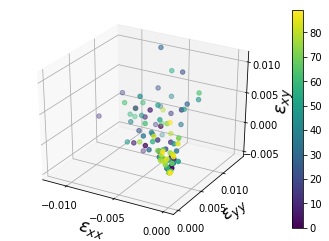

In [64]:
#Data access pattern
from mpl_toolkits.mplot3d import Axes3D
my_data=scaler.inverse_transform(new_data.iloc[:,0:6])
t = np.arange(len(my_data))
#fig, ax = plt.subplots(projection='3d')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax=plt.gca()
# naming the x axis
ax.set_xlabel('$\epsilon_{xx}$',fontname="Arial", fontsize=18)
ax.locator_params(nbins=5, axis='x')
#plt.tick_params(direction='in', labelsize='small')
#plt.xticks(fontsize=14)
# naming the y axis
ax.set_ylabel('$\epsilon_{yy}$',fontname="Arial", fontsize=18)
ax.locator_params(nbins=5, axis='y')
#plt.yticks(fontsize=14)     # To change the y-axis
# naming the z axis
ax.set_zlabel('$\epsilon_{xy}$',fontname="Arial", fontsize=18)
ax.locator_params(nbins=5, axis='z')
#plt.zticks(fontsize=14)     # To change the y-axis
# The spines
#plt.setp(ax.spines.values(), linewidth=2)
p=ax.scatter(my_data[:,0], my_data[:,1], my_data[:,2],c=t,cmap='viridis')
fig.colorbar(p)
plt.show()

In [ ]:
df_pred=pd.read_csv("pred.csv", header=None)
pred=np.array(df_pred, dtype=float)
new_pred,sigma_orig=gp.predict(pred[:, 0:4], return_std=True)
print(new_pred)
print(sigma_orig)
plt.plot(pred[:,4],new_pred, marker='o')

In [67]:
data_imp

array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [-6.040000e-05,  2.393940e-04,  1.590920e-04,  7.596421e+00,
         2.068286e+00,  2.106209e-01],
       [-1.088998e-03,  2.264467e-03,  1.041864e-03,  4.778105e+01,
         1.548055e+01,  1.348015e+00],
       ...,
       [ 1.450000e-17,  1.530000e-17,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [-1.638293e-03,  3.465541e-03,  1.708638e-03,  7.453197e+01,
         2.391517e+01,  2.231139e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])